In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from pricing.pricing.models.sig_vol import SigVol
from pricing.pricing.models.stat_sig_vol import StatSigVol
from pricing.pricing.models.model_params import LewisParams
from pricing.pricing.products.vanilla_option import VanillaOption
from pricing.pricing.calibration.calibration import Calibration
from pricing.pricing.calibration.calibration_params import CalibrationParams
from pricing.pricing.market_data.market_data_vanilla import MarketDataVanilla
from signature.signature.shuffle import shuffle_product
from signature.signature.characteristic_function import psi_riccati_euler, xi_riccati, psi_riccati_rk4, func_psi
from signature.signature.characteristic_function import psi_riccati_euler_stat, psi_riccati_pece_stat, func_psi_stat
from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 6, 6)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True

/home/mr_giraffe/anaconda3/envs/signature/lib/python3.8/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
%%time
ta = TensorAlgebra(2)

Compiling...
Compilation finished.
CPU times: user 2min 57s, sys: 326 ms, total: 2min 58s
Wall time: 2min 58s


In [ ]:
[ -0.40269106  -0.17778659  22.66471344   0.09348788 -10.04101382
  -9.79785638   6.08176545 -10.88537873 -40.93921529  16.92637344
 -32.02800265 -25.11234949  39.11175762 -10.61706648   3.45894698
  48.80506296]

In [4]:
N = 3
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

## SigVol and StatSigVol

In [4]:
rho = -0.5

model_sig = SigVol( 
    vol_ts=0.2 * Ø + _2, 
    ta=ta, 
    rho=rho
)

model_stat_sig = StatSigVol( 
    vol_ts=0.2 * Ø + _2 + 5 * _222, 
    ta=ta, 
    rho=rho,
    lam=5
)

61 ms -> 47 ms

In [28]:
%%time
k = np.linspace(-0.1, 0.1, 20)
option = VanillaOption(T=0.1, K=np.exp(k))
iv_sig = option.get_price(model=model_sig, method="lewis", F0=1, is_vol_surface=True, pricing_params=LewisParams(cf_timestep=0.001))

CPU times: user 711 ms, sys: 0 ns, total: 711 ms
Wall time: 106 ms


In [168]:
%%time
iv_stat_sig = option.get_price(model=model_stat_sig, method="lewis", F0=1, is_vol_surface=True, pricing_params=LewisParams())

CPU times: user 4.13 s, sys: 15.9 ms, total: 4.14 s
Wall time: 607 ms


In [97]:
%load_ext autoreload
%autoreload 2

from signature.signature.shuffle import shuffle_product
from signature.signature.numba_utility import combinations, factorial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
%%timeit

a = 122121121
b = 122211212

shuffle_product(a, b)

23.8 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
shuffle_product(12, 12)

(array([1122, 1212]), array([4, 2]))

In [8]:
a = 122121121
b = 122211212

shuffle_product(a, b)

Get letters: 8.875600178726017e-05
Combinations: 0.006138605996966362
Indices: 0.005628707993309945
Get shuffle: 0.7812485250178725
Sort shuffle: 0.002174135996028781
Get counts: 0.00014396299957297742


(array([112212112122211216, 112212112212211216, 112212112221121200, ...,
        122212212112112112, 122212212112112128, 122212212112121120]),
 array([2, 4, 4, ..., 6, 2, 1]))

In [6]:
import numba as nb
from numpy import int64

BASIS = 5


@nb.jit(nopython=True)
def get_word_size(word: int, basis=BASIS) -> int:
    if word == 0:
        return 0
    return int(np.log(word) / np.log(basis) + 1.)

@nb.jit(nopython=True)
def get_sub_indices(k: int, r: int) -> np.ndarray:
    orders = np.ones(shape=(r, k+1), dtype=int64)
    orders[0] = np.arange(k+1, dtype=int64)
    for j in range(1, r):
        repeats = k + j - orders[j - 1]
        repeated_orders = np.empty(shape=(orders.shape[0], repeats.sum()), dtype=int64)
        for li, line in enumerate(orders):
            repeated_orders[li] = line.repeat(repeats=repeats)
        orders = repeated_orders.copy()

        indices = np.cumsum(repeats)
        for i, ind in enumerate(indices[:-1]):
            orders[j, ind] = 1 - repeats[i+1]
        orders[j, 0] = j
        orders[j] = np.cumsum(orders[j])
    return orders.T

@nb.jit(nopython=True)
def get_indices(p: int, q: int) -> np.ndarray:
    left_indices  = get_sub_indices(k=q, r=p)
    right_indices = get_sub_indices(k=p, r=q)[::-1]
    return np.hstack((left_indices, right_indices))

@nb.jit(nopython=True)
def get_letters(word: int, basis=BASIS) -> (np.ndarray, int):
    word_size = get_word_size(word, basis=basis)
    letters = np.empty(shape=word_size, dtype=int64)
    for i in range(word_size):
        power  = basis ** (word_size - i - 1)
        letter = word // power
        word  -= letter * power
        letters[i] = letter
    return letters, word_size

@nb.jit(nopython=True)
def shuffle_product_2(left_word: int, right_word: int, basis=BASIS) -> np.ndarray:
    if left_word == 0:
        return np.array([right_word])
    if right_word == 0:
        return np.array([left_word])

    left_letters,  left_size  = get_letters(left_word, basis=basis)
    right_letters, right_size = get_letters(right_word, basis=basis)

    letters = np.hstack((left_letters, right_letters))

    indices = get_indices(left_size, right_size)
    powers  = left_size + right_size - indices - 1

    fbasis  = float(basis)
    shuffle = np.zeros(shape=len(powers), dtype=int64)
    for p in range(len(powers)):
        for le, letter in enumerate(letters):
            shuffle[p] += fbasis ** powers[p, le] * letter

    return shuffle

In [10]:
shuffle_product_2(22, 12, basis=4)

array([364, 376, 370, 472, 466, 454, 856, 850, 838, 790])

## Market Data

In [5]:
df = pd.read_csv("../../pricing/data/implied_volatility/spx_2013-08-14.csv")
maturities = np.sort(df.Expiration.unique())
df

,Expiration,CallPut,ImpliedVolatility,log_moneyness,iv_bid,iv_offer
0,0.024641,P,0.3910,-0.171175,0.376393,0.402286
1,0.024641,P,0.3764,-0.164173,0.362260,0.387329
2,0.024641,P,0.3619,-0.157239,0.348226,0.372473
3,0.024641,P,0.3475,-0.150373,0.334291,0.357719
4,0.024641,P,0.3510,-0.143464,0.342824,0.358056
...,...,...,...,...,...,...
1262,2.346386,C,0.1457,0.250836,0.139175,0.151878
1263,2.346386,C,0.1425,0.297255,0.133663,0.150423
1264,2.346386,C,0.1414,0.319765,0.130852,0.150461
1265,2.346386,C,0.1442,0.425236,0.134989,0.151629


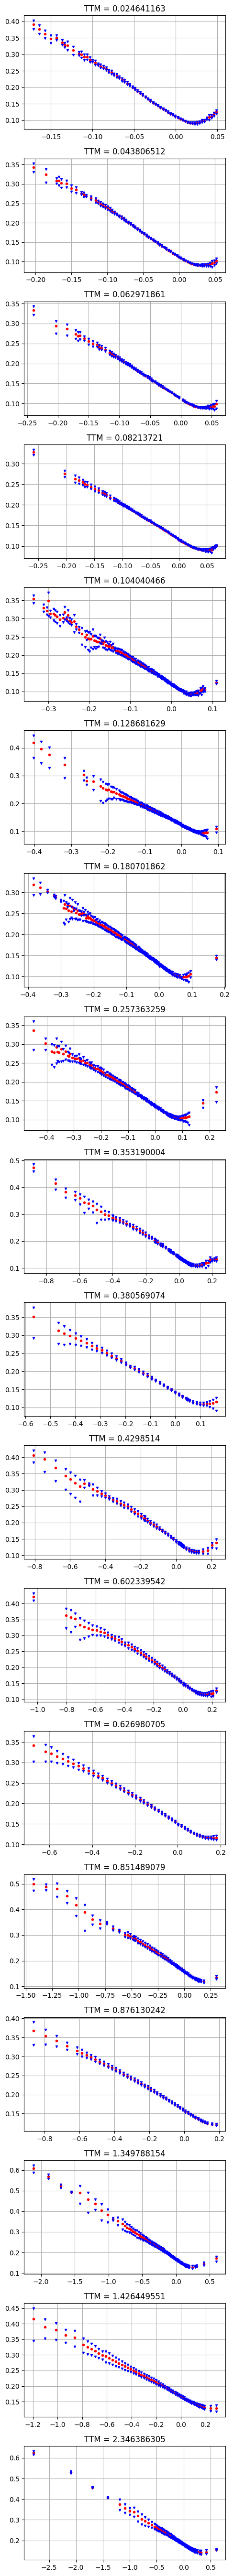

In [6]:
fig, ax_arr = plt.subplots(len(maturities), 1, figsize=(5, len(maturities) * 3))

ms = 3

vanilla_options = []

for ax, T in zip(ax_arr, maturities):
    k = df[df.Expiration == T].log_moneyness
    vanilla_options.append(VanillaOption(T=T, K=np.exp(k)))
    iv = df[df.Expiration == T].ImpliedVolatility
    ax.plot(k, iv, "ro", ms=ms)
    ax.plot(k, df[df.Expiration == T].iv_bid, "bv", ms=ms)
    ax.plot(k, df[df.Expiration == T].iv_offer, "bv", ms=ms)
    ax.set_title(f"TTM = {T}")

In [7]:
N = 3
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

In [8]:
rho = -0.8

model = SigVol( 
    vol_ts=0.2 * Ø, 
    ta=ta, 
    rho=rho
)

Text(0.5, 1.0, 'TTM = 0.024641163')

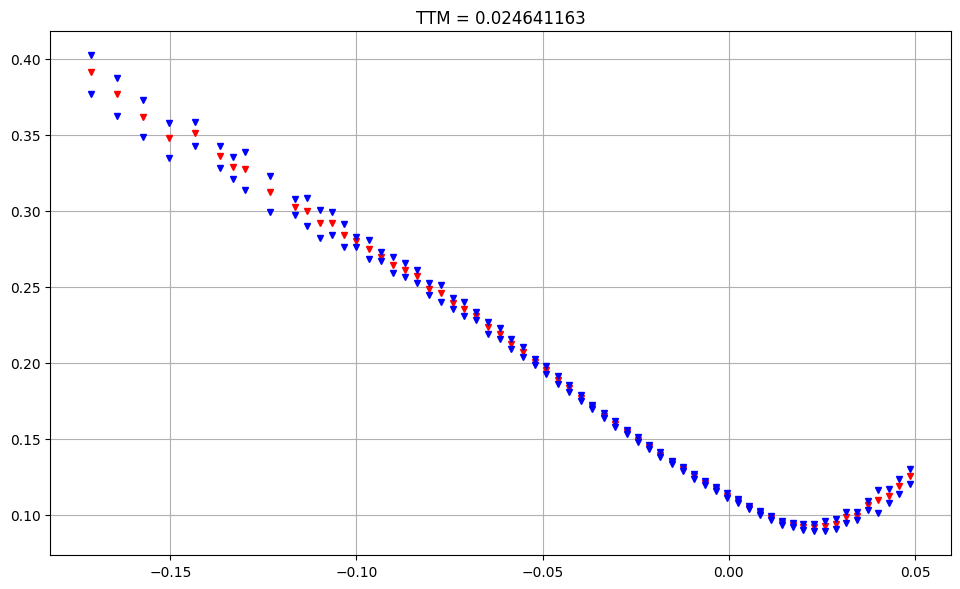

In [9]:
T = maturities[0]
k = df[df.Expiration == T].log_moneyness
vanilla_option = VanillaOption(T=T, K=np.exp(k))
iv = np.array(df[df.Expiration == T].ImpliedVolatility)
md = MarketDataVanilla(
    product=vanilla_option, 
    price=vanilla_option.black_vanilla_price(sigma=iv, F=1, r=0, flag=vanilla_option.flag), 
    implied_volatility=iv
)

ms = 5
plt.plot(k, iv, "rv", ms=ms)
plt.plot(k, df[df.Expiration == T].iv_bid, "bv", ms=ms)
plt.plot(k, df[df.Expiration == T].iv_offer, "bv", ms=ms)
plt.title(f"TTM = {T}")

In [10]:
market_data_array = [md]

In [33]:
# Automatize the construction of vector_to_params
def vector_to_params(x):
    model_params_dict = {
        "rho": x[0],
        "vol_ts": ta.from_array(trunc=model.vol_ts.trunc, array=x[1:])
    }
    return model_params_dict

bounds = [(-1, 0)] + [(-150, 150)] * (2**(N + 1) - 2) + [(0, 150)]

In [34]:
calibration_params = CalibrationParams(
    params_to_calibrate=("vol_ts", "rho"), 
    pricing_params=LewisParams(cf_timestep=0.001, N_points=30, control_variate_sigma=0.15), 
    vector_to_params=vector_to_params, 
    bounds=bounds, 
    optimiser="Differential-evolution"
)

In [35]:
calibration = Calibration(model=model, market_data_array=market_data_array, F0=1, calibration_parameters=calibration_params)

In [15]:
x0 = [-0.40269106, -0.17778659, 22.66471344, 0.09348788, -10.04101382, -9.79785638, 6.08176545, -10.88537873, -40.93921529, 16.92637344, -32.02800265, -25.11234949, 39.11175762, -10.61706648, 3.45894698, 48.80506296]
x0

[-0.40269106,
 -0.17778659,
 22.66471344,
 0.09348788,
 -10.04101382,
 -9.79785638,
 6.08176545,
 -10.88537873,
 -40.93921529,
 16.92637344,
 -32.02800265,
 -25.11234949,
 39.11175762,
 -10.61706648,
 3.45894698,
 48.80506296]

In [768]:
%%time
# x0 = np.array([-0.6] + [0.2] + [0.1] * (2**(N + 1) - 1 - 2) + [10]) 
calibration.loss(x=x0)

CPU times: user 10.7 s, sys: 19.9 ms, total: 10.7 s
Wall time: 1.79 s


0.002488220003554647

In [38]:
%%time

calibration.calibrate_model(x0=x0)

Calibrating model parameters...
New iteration: 
 x = [ -0.40403107  -0.15924963  21.99338455   0.39074997 -16.29956049
 -18.24012007 -17.8237876  -11.08993543 -21.06512984  23.26466012
 -44.23908456 -45.6162886   18.47555135  14.65172385 -36.83112434
  48.8219102 ], 
 val=0.002669441800376034. 

Convergence = 0.029586113929544248
New iteration: 
 x = [ -0.40403107  -0.15924963  21.99338455   0.39074997 -16.29956049
 -18.24012007 -17.8237876  -11.08993543 -21.06512984  23.26466012
 -44.23908456 -45.6162886   18.47555135  14.65172385 -36.83112434
  48.8219102 ], 
 val=0.002669441800376034. 

Convergence = 0.02123851247242936
New iteration: 
 x = [ -0.40403107  -0.15924963  21.99338455   0.39074997 -16.29956049
 -18.24012007 -17.8237876  -11.08993543 -21.06512984  23.26466012
 -44.23908456 -45.6162886   18.47555135  14.65172385 -36.83112434
  48.8219102 ], 
 val=0.002669441800376034. 

Convergence = 0.015350511206880784
New iteration: 
 x = [ -0.40403107  -0.15924963  21.99338455   0.3907

KeyboardInterrupt: 

In [39]:
", ".join("""-0.8586965    0.20235113 -21.10836261   0.51914494 102.43332041
   9.00619651 -88.0105371    5.75995167 -37.85410832 -26.00831587
  61.78519443  27.42967485 -98.88901332  21.17172793   5.89084568
  46.80119952""".split())

'-0.8586965, 0.20235113, -21.10836261, 0.51914494, 102.43332041, 9.00619651, -88.0105371, 5.75995167, -37.85410832, -26.00831587, 61.78519443, 27.42967485, -98.88901332, 21.17172793, 5.89084568, 46.80119952'

In [40]:
x1 = [-0.8586965, 0.20235113, -21.10836261, 0.51914494, 102.43332041, 9.00619651, -88.0105371, 5.75995167, -37.85410832, -26.00831587, 61.78519443, 27.42967485, -98.88901332, 21.17172793, 5.89084568, 46.80119952]

In [41]:
calibration.loss(x1)

0.00010694273220447092

In [22]:
ta.print(model.vol_ts)

-0.15924963*∅ + 21.99338455*1 + 0.39074997*2 + -16.29956049*11 + -18.24012007*12 + -17.8237876*21 + -11.08993543*22 + -21.06512984*111 + 23.26466012*112 + -44.23908456*121 + -45.6162886*122 + 18.47555135*211 + 14.65172385*212 + -36.83112434*221 + 48.8219102*222


In [465]:
T = 0.03
t_grid = np.linspace(0, T, 1000)
rng = np.random.default_rng(seed=43)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

path = np.vstack([t_grid, W]).T
W_sig = ta.path_to_sequence(path=path, trunc=4)

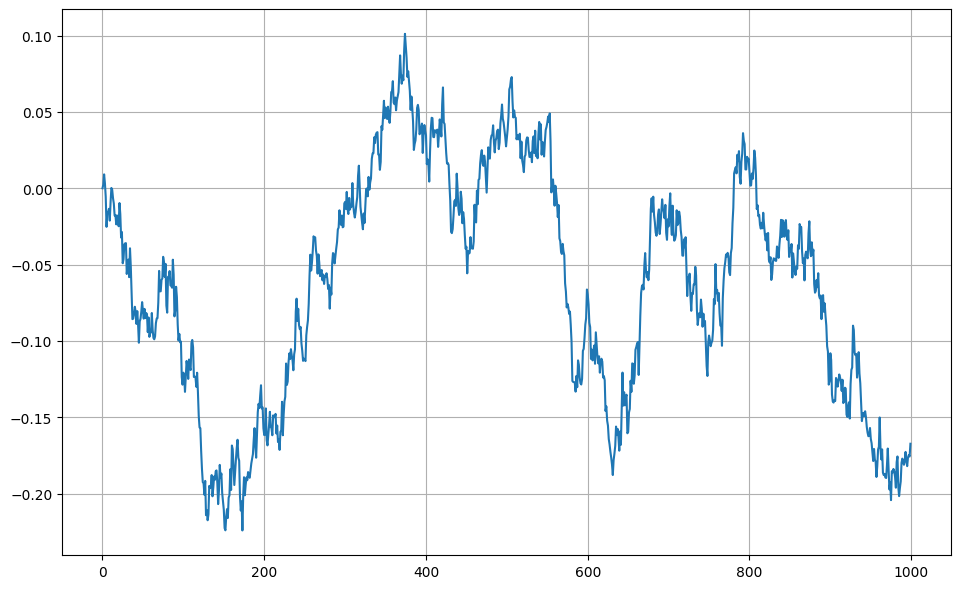

In [759]:
s0 = 0.
lam = 20
theta = 0.
nu = 1.8

x0 = np.array([-0.75] + [0] * (2**(N + 1) - 1)) 

l_OU = (Ø * s0 + _1 * lam * theta + _2 * nu).tensor_prod((-lam * _1).shuffle_exp(12))
x0[1 + l_OU.indices] = l_OU.array.real.flatten()

plt.plot((l_OU @ W_sig).real.flatten())

In [741]:
x0

array([ -0.75,   0.  ,   0.  ,   1.8 ,   0.  ,   0.  , -36.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  , 720.  ,   0.  ,   0.  ,   0.  ])

In [756]:
x0_noisy = x0

In [761]:
x0[-1] = 5
x0[12] = 50
x0 = x0 + np.random.randn(16) * 0.01
print(x0)
print(calibration.loss(x0))
ta.print(calibration.model.vol_ts)

[-7.35426016e-01  1.47014135e-02 -3.36524277e-03  1.80072281e+00
 -1.51526485e-02 -5.41608916e-03 -3.60010601e+01 -8.77573817e-03
 -5.14544346e-03  6.55568165e-03  1.11107155e-02  8.22635099e-03
  4.99973771e+01  2.19901640e-03 -8.00650106e-03  4.99585527e+00]
0.002491605228234076
0.014701413510991057*∅ + -0.003365242768322999*1 + 1.8007228055540103*2 + -0.01515264847756473*11 + -0.005416089158452253*12 + -36.00106013963679*21 + -0.008775738168555397*22 + -0.005145443460760702*111 + 0.006555681648181471*112 + 0.011110715463476922*121 + 0.008226350987525879*122 + 49.997377098829574*211 + 0.0021990163969396767*212 + -0.008006501059855113*221 + 4.995855266468747*222


In [50]:
ta.print(calibration.model.vol_ts)

0.20235113*∅ + -21.10836261*1 + 0.51914494*2 + 102.43332041*11 + 9.00619651*12 + -88.0105371*21 + 5.75995167*22 + -37.85410832*111 + -26.00831587*112 + 61.78519443*121 + 27.42967485*122 + -98.88901332*211 + 21.17172793*212 + 5.89084568*221 + 46.80119952*222


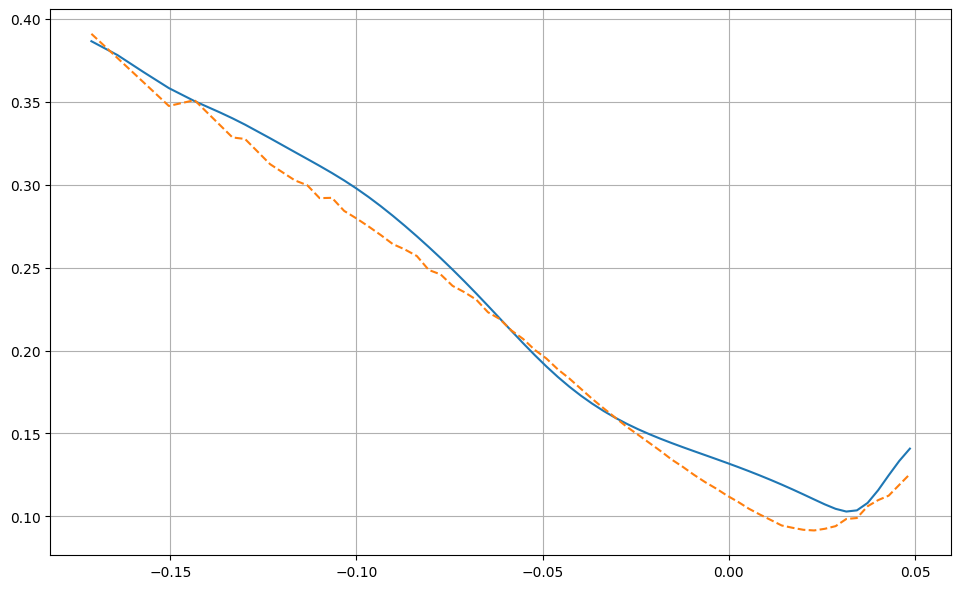

In [49]:
calibration.update_model_parameters(x1)

from dataclasses import asdict


iv = vanilla_option.get_price(
    model=calibration.model,
    method=calibration.calibration_parameters.pricing_method,
    F0=calibration.F0,
    is_vol_surface=True,
    **asdict(LewisParams(cf_timestep=0.0005, N_points=50, control_variate_sigma=0.2))
)

plt.plot(np.log(vanilla_option.K).squeeze(), iv)
plt.plot(np.log(vanilla_option.K).squeeze(), md.implied_volatility, "--")